In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.layers.normalization import batch_normalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.utils import plot_model
from scipy import stats

Parameters and Constants

In [3]:
COLUMNS = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
    "occupation", "relationship", "race", "gender", "capital_gain", "capital_loss", 
    "hours_per_week", "native_country", "income_bracket"
]

LABEL_COLUMN = "label"

OUTLIER_COLUMN = "Voice_INCOMING_Outlier"

CATEGORICAL_COLUMNS = [
    "workclass", "education", "marital_status", "occupation", "relationship", 
    "race", "gender", "native_country"
]

CONTINUOUS_COLUMNS = [
    "age", "education_num", "capital_gain", "capital_loss", "hours_per_week"
]

MODE, NO_OF_EPHOCS, OPTIMIZER, BATCH_SIZE = 'wide and deep', 60, 'adam', 64

Pre-processing

In [31]:
# one hot encoder
def oneHotEncoder(array_1d):
    label = LabelEncoder().fit_transform(array_1d)
    label = label.reshape(len(label), 1)
    one_hot = OneHotEncoder(sparse=False).fit_transform(label)
    return one_hot

# min-max scaler
def minMaxScale(array_2d):
    return MinMaxScaler().fit_transform(array_2d)

# Turkey's box-plot method to clip outliers
def outliers(s, replace=np.nan):
    Q1, Q3 = np.percentile(s, [25 ,75])
    IQR = Q3-Q1
    return s.where((s > (Q1 - 1.5 * IQR)) & (s < (Q3 + 1.5 * IQR)), replace)

# clip outliers
def drop_numerical_outliers(df, cols):
  df[cols] = df[cols].apply(outliers)
  return df

# handle pre-defined outliers
def handle_outliers(df, col):
  return df[(df[col] != "YES")]

# drop unwanted cols
def drop_cols(df, columns):
  cols_to_drop = []
  for col in columns:
    if col not in df.columns:
      cols_to_drop.append(col)
  return df.drop(cols_to_drop, axis=1)

In [28]:
user_content = pd.read_csv("drive/MyDrive/slt_data/peoTV_user_content.csv")
user_ratings = pd.read_csv("drive/MyDrive/slt_data/peoTV_user_ratings.csv")
package_content = pd.read_csv("drive/MyDrive/slt_data/peoTV_package_content.csv")

In [29]:
# drop unwanted columns
try:
  user_content.drop(["Unnamed: 0"], axis=1, inplace=True)
  user_ratings.drop(["Unnamed: 0"], axis=1, inplace=True)
except:
  pass

# join into a single table
all_data = user_ratings.merge(user_content, how="left", on="ACCOUNT_NUM.hash")

# drop unused columns for analysis
#all_data = drop_cols(all_data, COLUMNS)

# clip outliers
all_data = handle_outliers(all_data,OUTLIER_COLUMN)

# fill null vlaues
all_data.dropna(how="any", axis=0, inplace = True)

In [ ]:
# train_data = pd.read_csv('./drive/MyDrive/slt_data/adult.data', names=COLUMNS)
# train_data.dropna(how='any', axis=0)
# test_data = pd.read_csv('./drive/MyDrive/slt_data/adult.test', skiprows=1, names=COLUMNS)
# test_data.dropna(how='any', axis=0)
# all_data = pd.concat([train_data, test_data])

# train_size = len(train_data)
# x_train = all_data.iloc[:train_size]
# y_train = y[:train_size]
# x_test = all_data.iloc[train_size:]
# y_test = y[train_size:]

Encoding

In [ ]:
  all_data[LABEL_COLUMN] = all_data['income_bracket'].apply(lambda x: ">50K" in x).astype(int)
  all_data.pop('income_bracket')
  y = all_data[LABEL_COLUMN].values
  all_data.pop(LABEL_COLUMN)
  for c in CATEGORICAL_COLUMNS:
      le = LabelEncoder()
      all_data[c] = le.fit_transform(all_data[c])

Defining Labels

In [ ]:
# func to define labels based on most rated items
# TO EDIT
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

Train set, Test set preparation

In [6]:
# train test splitting
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

x_train_categ = np.array(x_train[CATEGORICAL_COLUMNS]) 
x_test_categ = np.array(x_test[CATEGORICAL_COLUMNS])
x_train_conti = np.array(x_train[CONTINUOUS_COLUMNS], dtype='float64') 
x_test_conti = np.array(x_test[CONTINUOUS_COLUMNS], dtype='float64')
scaler = StandardScaler()
x_train_conti = scaler.fit_transform(x_train_conti)
x_test_conti = scaler.transform(x_test_conti)

Wide and Deep Model

In [7]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
        # cross product transformations
x_train_categ_poly = poly.fit_transform(x_train_categ)
x_test_categ_poly = poly.transform(x_test_categ)

In [21]:
def deep_component(cat_cols,con_cols, all_data):
        categ_inputs = []
        categ_embeds = []

        # Embedding Categorical Inputs
        for i in range(len(cat_cols)):
            input_i = Input(shape=(1,), dtype='int32')
            dim = len(np.unique(all_data[cat_cols[i]]))
            embed_dim = int(np.ceil(dim ** 0.25)) # Embedding
            embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
            flatten_i = Flatten()(embed_i)
            categ_inputs.append(input_i)
            categ_embeds.append(flatten_i)
        conti_input = Input(shape=(len(con_cols),))
        conti_dense = Dense(256, use_bias=False)(conti_input)
        concat_embeds = concatenate([conti_dense]+categ_embeds)
        concat_embeds = Activation('relu')(concat_embeds)
        bn_concat = batch_normalization.BatchNormalization()(concat_embeds)

        # Busiling Deep model Hidden layers and Output layer
        fc1 = Dense(512, use_bias=False)(bn_concat)
        ac1 = ReLU()(fc1)
        bn1 = batch_normalization.BatchNormalization()(ac1)
        fc2 = Dense(256, use_bias=False)(bn1)
        ac2 = ReLU()(fc2)
        bn2 = batch_normalization.BatchNormalization()(ac2)
        fc3 = Dense(128)(bn2)
        ac3 = ReLU()(fc3)

        return categ_inputs, conti_input, ac3

In [9]:
def wide_component(x_train_categ_poly):
        dim = x_train_categ_poly.shape[1]
        return Input(shape=(dim,))

In [28]:
def create_model(mode,deep_component_outlayer, logistic_input, categ_inputs, conti_input):
        if mode == 'wide and deep':
            out_layer = concatenate([deep_component_outlayer, logistic_input])
            inputs = [conti_input] + categ_inputs + [logistic_input]
        elif mode =='deep':
            out_layer = deep_component_outlayer
            inputs = [conti_input] + categ_inputs
        else:
            print('wrong mode selected')
            return

        output = Dense(1, activation='sigmoid')(out_layer)
        return Model(inputs=inputs, outputs=output)

In [35]:
def train_model(mode,model,x_train_conti, x_train_categ,x_train_categ_poly,y_train, epochs=15, optimizer='adam', batch_size=128):
        if not model:
            print('Need to create model first')
            return

        if mode == 'wide and deep':
            input_data = [x_train_conti] +\
                         [x_train_categ[:, i] for i in range(x_train_categ.shape[1])] +\
                         [x_train_categ_poly]
        elif mode == 'deep':
            input_data = [x_train_conti] +\
                         [x_train_categ[:, i] for i in range(x_train_categ.shape[1])]
        else:
            print('wrong mode selected')
            return
        
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(input_data, y_train, epochs=epochs, batch_size=batch_size)
        return model

In [ ]:
# Confidence Score calculation

# Provide list of top-N recommendations

In [12]:
def evaluate_model(mode, model, x_test_conti, x_test_categ, x_test_categ_poly, y_test):
        if not model:
            print('need to create and train model first')
            return

        if mode == 'wide and deep':
            input_data = [x_test_conti] +\
                         [x_test_categ[:, i] for i in range(x_test_categ.shape[1])] +\
                         [x_test_categ_poly]
        elif mode == 'deep':
            input_data = [x_test_conti] +\
                         [x_test_categ[:, i] for i in range(x_test_categ.shape[1])]
        else:
            print('wrong mode selected')
            return

        return model.evaluate(input_data, y_test)

In [ ]:
# Cross Validation logic/ function

In [ ]:
# NDGC

# MAP

In [36]:
def save_model(model, filename='wide_and_deep.h5'):
        model.save(filename)

Execution

In [37]:
# wide and deep components
categ_inputs, conti_input, deep_component_outlayer = deep_component(CATEGORICAL_COLUMNS,CONTINUOUS_COLUMNS,all_data)
logistic_input = wide_component(x_train_categ_poly)

In [38]:
# create model
created_model = create_model(MODE,deep_component_outlayer, logistic_input, categ_inputs, conti_input)

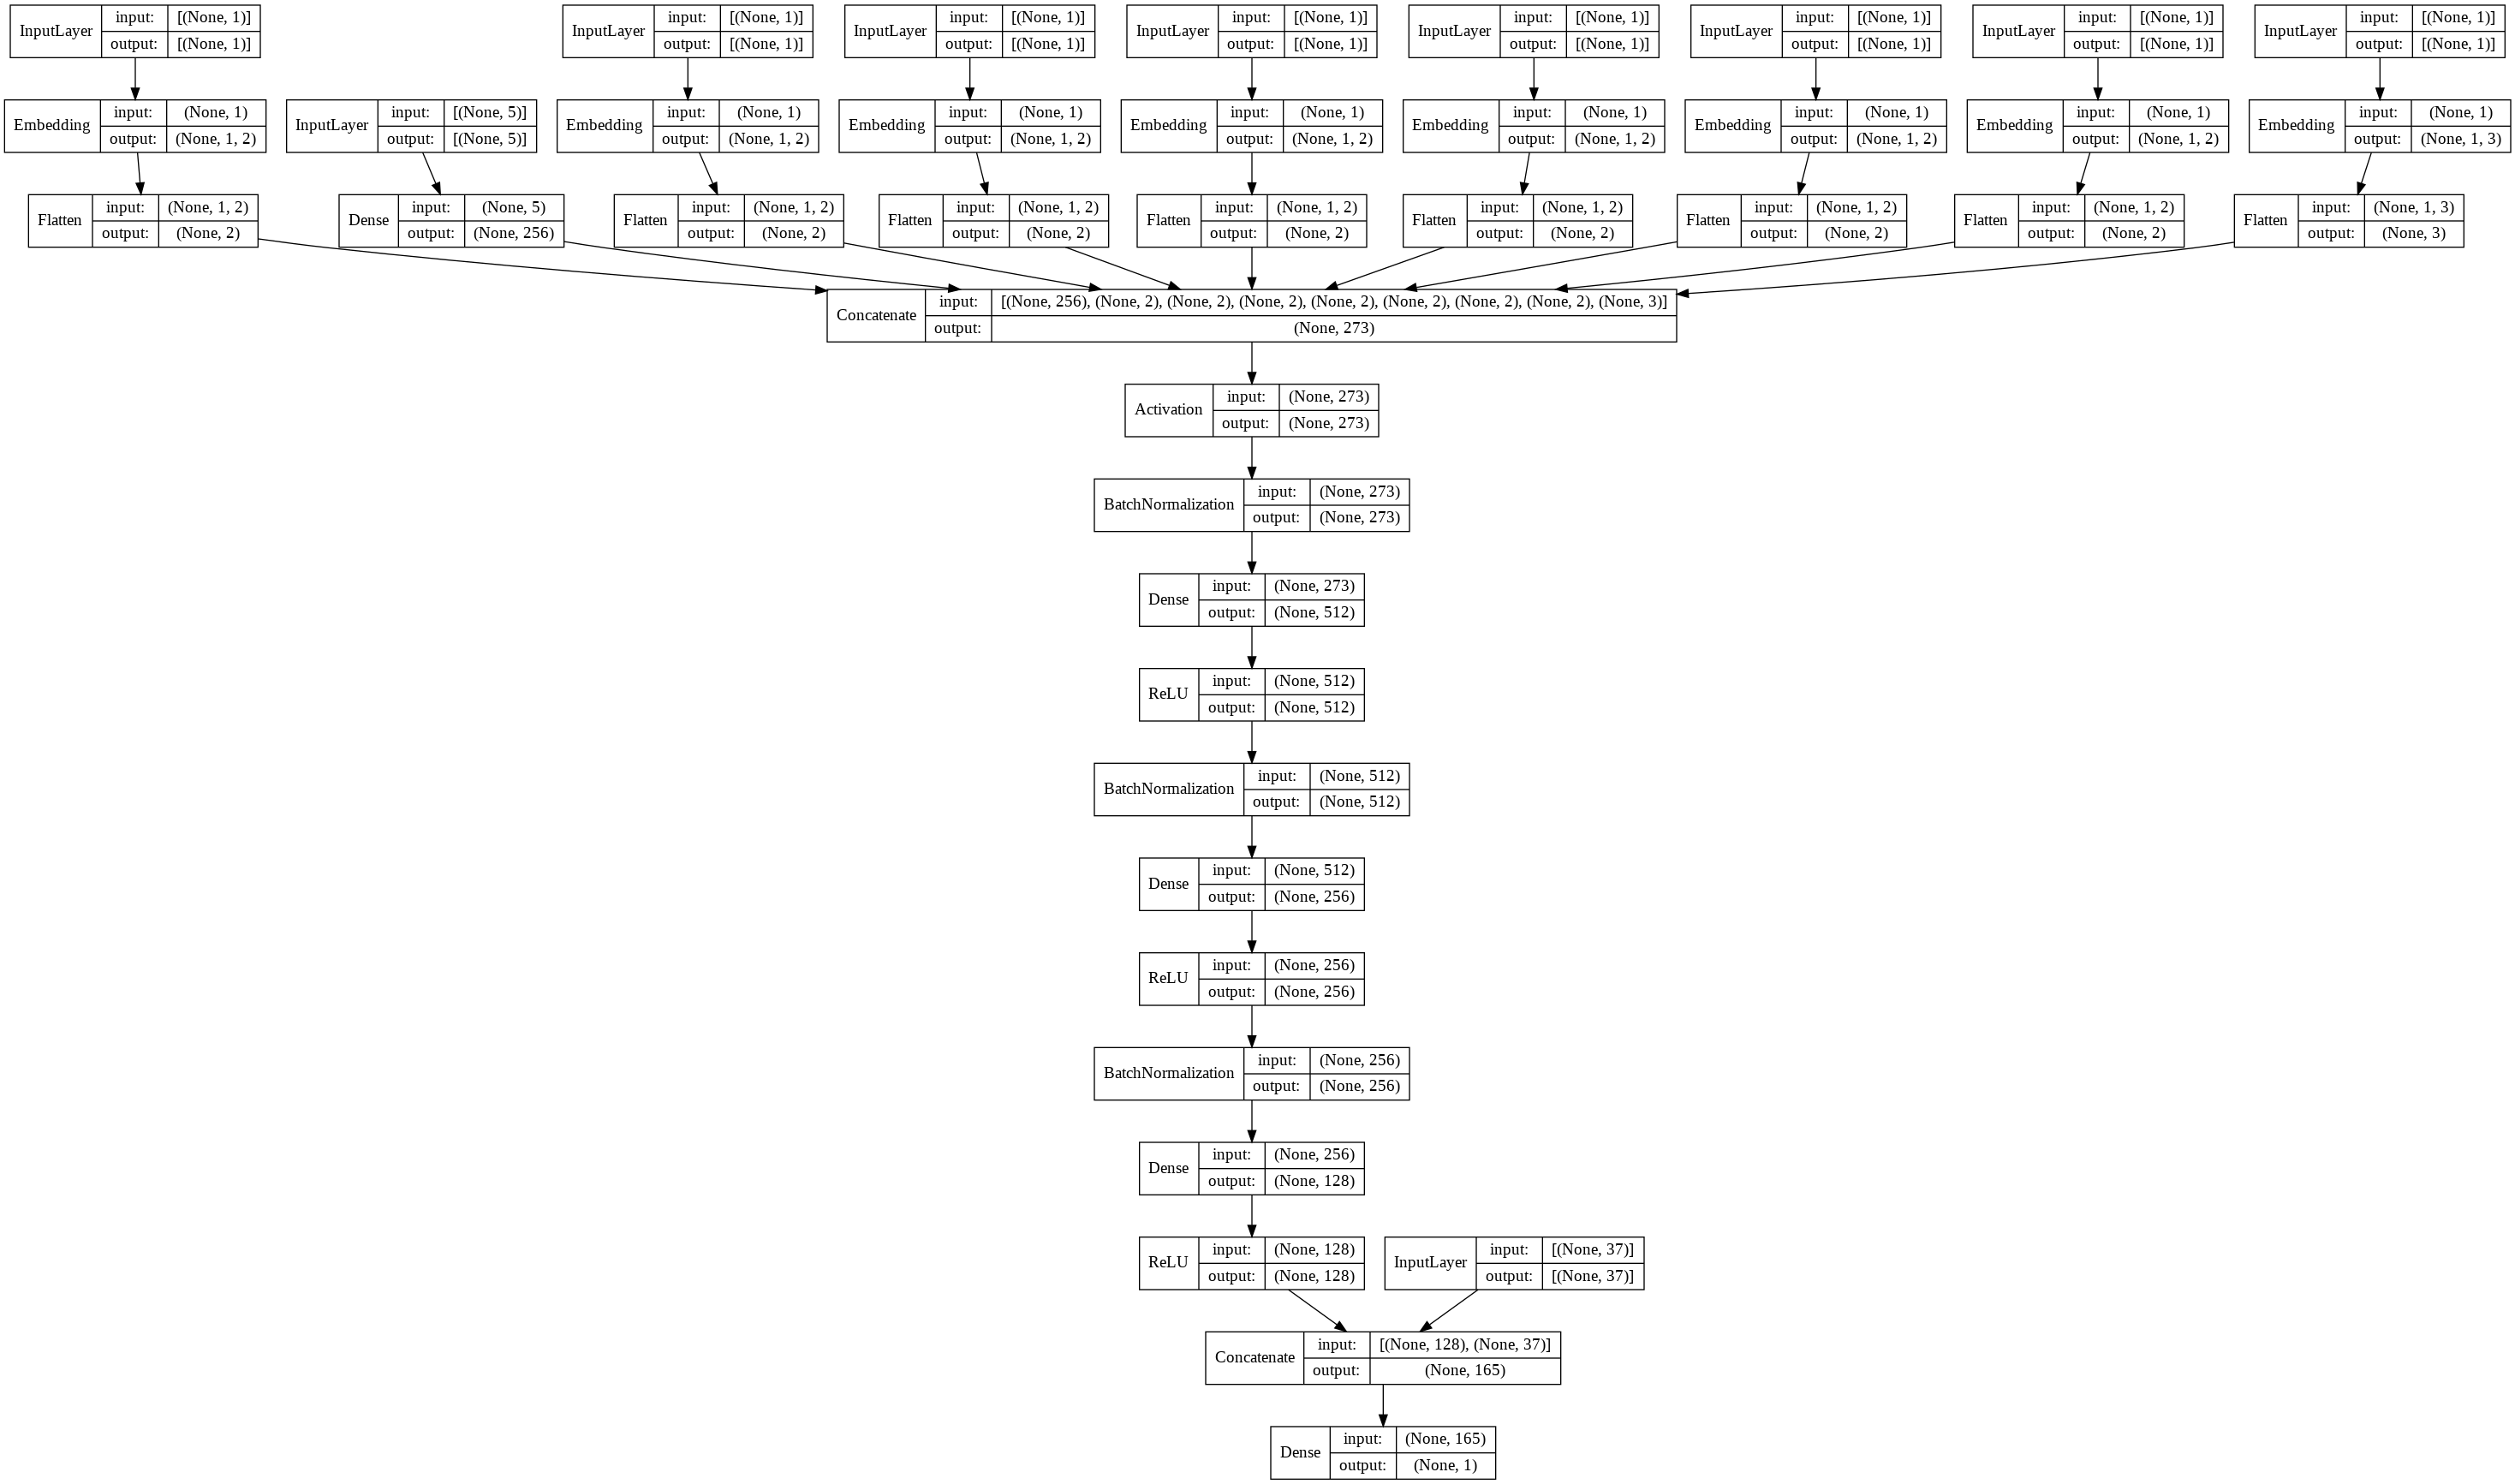

In [39]:
# plot model tree
plot_model(created_model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [40]:
# train model
trained_model = train_model(MODE,created_model,x_train_conti, x_train_categ,x_train_categ_poly,y_train, NO_OF_EPHOCS, OPTIMIZER, BATCH_SIZE)

Epoch 1/60
509/509 [==============================] - 7s 10ms/step - loss: 0.9485 - accuracy: 0.7969
Epoch 2/60
509/509 [==============================] - 5s 10ms/step - loss: 0.3867 - accuracy: 0.8259
Epoch 3/60
509/509 [==============================] - 5s 10ms/step - loss: 0.3621 - accuracy: 0.8320
Epoch 4/60
509/509 [==============================] - 5s 10ms/step - loss: 0.3448 - accuracy: 0.8386
Epoch 5/60
509/509 [==============================] - 5s 10ms/step - loss: 0.3450 - accuracy: 0.8372
Epoch 6/60
509/509 [==============================] - 5s 10ms/step - loss: 0.3418 - accuracy: 0.8358
Epoch 7/60
509/509 [==============================] - 5s 10ms/step - loss: 0.3310 - accuracy: 0.8412
Epoch 8/60
509/509 [==============================] - 5s 10ms/step - loss: 0.3326 - accuracy: 0.8422
Epoch 9/60
509/509 [==============================] - 5s 10ms/step - loss: 0.3287 - accuracy: 0.8435
Epoch 10/60
509/509 [==============================] - 5s 10ms/step - loss: 0.3279 - accura

In [42]:
# evaluate model accuracy
loss, acc = evaluate_model(MODE, trained_model, x_test_conti, x_test_categ, x_test_categ_poly, y_test)
print(f'test_loss: {loss} - test_acc: {acc}')


509/509 [==============================] - 1s 3ms/step - loss: 0.4238 - accuracy: 0.8350
test_loss: 0.42376449704170227 - test_acc: 0.8350223898887634


In [33]:
# predictions and AUC

# model predictions
# y_pred = 

roc_auc_score(y_test, y_pred)

NameError: ignored

In [ ]:
# save model
save_model = (trained_model, "drive/MyDrive/slt_data/trained_model.h5")